# Hugging Face Demonstration with PyTorch
## Text Classification
### TP Goter
### January 25, 2021

In [7]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
import os
from pprint import pprint
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers, initializers

In [8]:
from transformers import TFElectraForSequenceClassification, ElectraTokenizer

In [9]:
from transformers import TFDistilBertForSequenceClassification

In [10]:
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'TensorFlow version: {tf.__version__}')

Numpy version: 1.18.5
Pandas version: 1.1.2
TensorFlow version: 2.3.1


## Load pre-trained BERT-Base model with tokenizer

In [6]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Using Subset of AG News Dataset

#### Sourced from [this GitHub repo](https://github.com/mhjabreel/CharCnn_Keras)
AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

In [5]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
emodel = TFElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=4)

In [ ]:
emodel.summary()

In [ ]:
dbmodel = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

In [ ]:
dbmodel.summary()

In [ ]:
TRAINING_DATA = './ag_news_csv/train.csv'
VAL_DATA = './ag_news_csv/test.csv' 

### Gather Training Data
Read in the CSV file into a pandas dataframe and then label the columns appropriately for easier access. The regex replacement takes care of line breaks in the training data.

In [ ]:
train_df = pd.read_csv(TRAINING_DATA, header=None)
train_df.columns = ['label', 'title', 'desc']
train_df.desc = train_df.desc.replace(r'\\', ' ', regex=True)

test_df = pd.read_csv(VAL_DATA, header=None)
test_df.columns = ['label', 'title', 'desc']
test_df.desc = test_df.desc.replace(r'\\', ' ', regex=True)

In [ ]:
train_df.label.value_counts()

In [ ]:
test_df.label.value_counts()

In [ ]:
# The labels are a column in the data frame - pop them into their own object
train_labels = train_df.label.values
train_labels = train_labels -1

# Get the training sentences
train_sentences = train_df.desc.values

# The labels are a column in the data frame - pop them into their own object
test_labels = test_df.label.values
test_labels = test_labels -1

# Get the training sentences
test_sentences = test_df.desc.values

In [ ]:
def create_dataset(sequences, labels, batch_size = 256):
    input_ids = []
    attention_mask = []
    token_ids = []
    
    num_examples = (len(sequences) // batch_size) * batch_size
    
    for sent in tqdm(sequences[:num_examples]):
        encoded_dict = tokenizer.encode_plus(sent,
                     add_special_tokens = True,
                     padding = 'max_length',
                     max_length = 128,
                     truncation = True,
                     return_attention_mask = True,
                     return_token_type_ids = True,
                     return_tensors = 'tf') 
        input_ids.append(tf.reshape(encoded_dict['input_ids'],[-1]))
        #token_ids.append(tf.reshape(encoded_dict['token_type_ids'],[-1]))
        attention_mask.append(tf.reshape(encoded_dict['attention_mask'],[-1]))
    
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': input_ids,
                                              #'token_type_ids':token_ids,
                                              'attention_mask':attention_mask}, labels[:num_examples]))
    
    return dataset
    

## Run the function above for both the training and test data

In [ ]:
training_dataset = create_dataset(train_sentences, train_labels)
test_dataset = create_dataset(test_sentences, test_labels)

In [47]:
training_dataset = training_dataset.repeat(2).batch(256)
test_dataset = test_dataset.repeat(2).shuffle(100)w

In [ ]:
dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100).batch(
    global_batch_size)
dist_dataset = mirrored_strategy.experimental_distribute_dataset(dataset)

In [31]:
batched_training_dataset = training_dataset.shuffle(1024).batch(256)
batched_test_dataset = test_dataset.shuffle(1024).batch(256)

In [11]:
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)
model.fit(training_dataset, epochs=2, steps_per_epoch=468, validation_data = test_dataset)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/40


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


20/20 [==============================] - 71s 4s/step - loss: 0.3026
Epoch 2/40
20/20 [==============================] - 72s 4s/step - loss: 0.1376
Epoch 3/40
20/20 [==============================] - 70s 4s/step - loss: 0.1167
Epoch 4/40
20/20 [==============================] - 69s 3s/step - loss: 0.1835
Epoch 5/40
20/20 [==============================] - 71s 4s/step - loss: 0.1886
Epoch 6/40
20/20 [==============================] - 96s 5s/step - loss: 0.1287
Epoch 7/40
20/20 [==============================] - 80s 4s/step - loss: 0.1494
Epoch 8/40
20/20 [==============================] - 77s 4s/step - loss: 0.1096
Epoch 9/40
20/20 [==============================] - 79s 4s/step - loss: 0.0982
Epoch 10/40
20/20 [==============================] - 77s 4s/step - loss: 0.0569
Epoch 11/40
20/20 [==============================] - 75s 4s/step - loss: 0.0682
Epoch 12/40
20/20 [==============================] - 75s 4s/step - loss: 0.0678
Epoch 13/40
20/20 [==============================] - 74s 4s/

## Running on IBM Cloud

1. Requistion a 2xV100 Node
2. Clone github repo https://github.com/tomgoter/hf_demo.git
3. Create docker image - `docker build -t transformer -f build.docker .`
4. Run the docker image with the GPUS interactively and spawn a bash interface - `nvidia-docker run -it --rm transformer bash`
5. Run the python script in background so you can monitor GPU usage- `nohup python multigpu_example.py -m MODELNAME -b BATCH_SIZE -l MAX_SEQUENCE_LENGTH&`
- MODELNAME is the actual name of the model stored on huggingface (e.g., 'bert-base-uncased'). There is a list of acceptable choices in the argument parser.
- BATCH_SIZE is the value per replica
- MAX_SEQUENCE_LENGTH is the length that each input sequence will be padded/truncated to. note that memory and runtime requires are proportional to the square of this value.
6. Monitor progress - `tail -f nohup.out`
7. Monitor GPU Utilization - `nvidia-smi`


## Model Evaluations
Each model was trained using ~120K labeled examples starting with pretrained weights. Only three finetuning epochs were used with no hyperparameter tuning. Timing results are from 2 V100s on the IBM Cloud with 16GB of RAM each. P100 performance is expected to be ~3x slower. TPUv3 performance is expected to be ~5-10x faster. Performance comparison is skewed because of the fixed training length. A more fair comparison of performance would use early stopping to determine total training time until convergence. All cases use a shuffle buffer size of 1024. Unclear to me at the moment why the memory allocation didn't change significantly with DistilBert vs BertBase. There is also a Distilled version of RoBerta that came available a couple of months ago. There is no automated sequence classification in Transformers yet though.

| Model | Global Batch Size | # GPUs | Batch Size per GPU | Max Token Length | Memory Usage| Minutes per Epoch | Ex per Minute | ValAccuracy |
| --- | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| BertBaseU       | 256 | 2 | 128  | 128 | OOM  | n/a | n/a | n/a |
| BertBaseU       | 128 | 2 | 64  | 128 | 15.3 | 10  | 13,200 | 0.935 |
| BertBaseU       | 128 | 2 | 64  | 64  | 15.3 | 5.0   | 23,600 | 0.937 |
| BertBaseU       | 256 | 2 | 128 | 64  | 15.3 | 4.5 | 26,900 | 0.935 |
| ---    | --- | --- | --- | ---  | --- | --- |---| --- | --- | 
| RobertaBase     | 128 | 2 | 64  | 128 | 15.3 | 10  | 13,200 | **0.944** |
| RobertaBase     | 128 | 2 | 64  | 64  | 15.3 | 5.0 | 23,600 | 0.939 |
| RobertaBase     | 128 | 2 | 64  | 32  | 15.3 | 3.0 | 39,000 | 0.926 |
| RobertaBase     | 256 | 2 | 128 | 64  | 15.3 | 4.5 | 26,900 | 0.939 |
| RobertaBase     | 256 | 2 | 128 | 128 | OOM | n/a | n/a | n/a |
| RobertaBase     | 512 | 2 | 256 | 64  | OOM | n/a | n/a | n/a |
| ---    | --- | --- | --- | ---  | --- | --- | --- | --- | 
| DistilBertBaseU | 256 | 2 | 128 | 128 | 15.3 | 1.8 | 71,400 | 0.865 |
| DistilBertBaseU | 256 | 2 | 128 | 64  | 15.3 | 0.9 | 133,300 | 0.858 |
| DistilBertBaseU | 512 | 2 | 256 | 128  | 15.3  | 1.5 | 77,800 | 0.846 |
| DistilBertBaseU | 512 | 2 | 256 | 64  | 15.3 | 0.80 | 150,000 | 0.816 |
| DistilBertBaseU | 1024 | 2 | 512 | 64  | 15.3 | 0.74 | **161,700** | 0.702 |
| --- | --- | --- | --- | ---  | --- | --- | --- | --- | 
| ElectraBaseU    | 256 | 2 | 128 | 64  | 15.3 | 4.5 | 27,100 | 0.927 |
| --- | --- | --- | --- | ---  | --- | --- | --- | --- | 
| 10 EPOCHS |  |  |  |   |  |  |  |  | 
| DistilBertBaseU | 256 | 2 | 128 | 128  | 15.3 | 1.8 | 71,400 | 0.899 |
| DistilBertBaseU | 256 | 2 | 128 | 64  | 15.3 |  0.9 | 133,300 | 0.898 |

## Scratch Area for Tokenization Exploration

In [41]:
token_ids = tokenizer.encode('spellingz iz harde')
[tokenizer.decode(token) for token in token_ids]

['[ C L S ]',
 's p e l l i n g',
 '# # z',
 'i',
 '# # z',
 'h a r d',
 '# # e',
 '[ S E P ]']

In [42]:
rtoken_ids = rtokenizer.encode('spellingz iz harde')
[rtokenizer.decode(rtoken) for rtoken in rtoken_ids]

['<s>', 'spe', 'lling', 'z', ' ', 'iz', ' hard', 'e', '</s>']

In [36]:
encoded_dict = tokenizer.encode_plus('spellingz',
                     add_special_tokens = True,
                     padding = 'max_length',
                     max_length = 128) 

In [44]:
tokens = []
for sent in tqdm(train_sentences):
    tokens.append(tokenizer.encode(sent))

100%|██████████| 120000/120000 [02:11<00:00, 910.84it/s] 


In [45]:
np.mean([len(t) for t in tokens])

43.359966666666665

In [46]:
np.max([len(t) for t in tokens])

372

In [47]:
np.min([len(t) for t in tokens])

5

In [48]:
token_lengths = [len(t) for t in tokens]

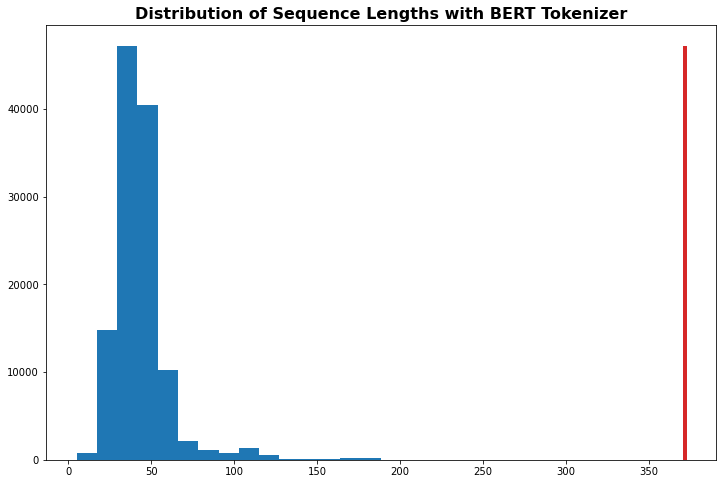

In [74]:
fig, ax =plt.subplots(1,1, figsize=(12,8))
h = ax.hist(token_lengths, bins=30)
ax.set_title('Distribution of Sequence Lengths with BERT Tokenizer', fontweight='bold',fontsize=16)
ax.vlines(np.max(token_lengths), 0, max(h[0]),color='tab:red', linewidth=4)

In [64]:
rtokens = []
for sent in tqdm(train_sentences):
    rtokens.append(rtokenizer.encode(sent))

100%|██████████| 120000/120000 [00:49<00:00, 2424.04it/s]


In [65]:
rtoken_lengths = [len(t) for t in rtokens]

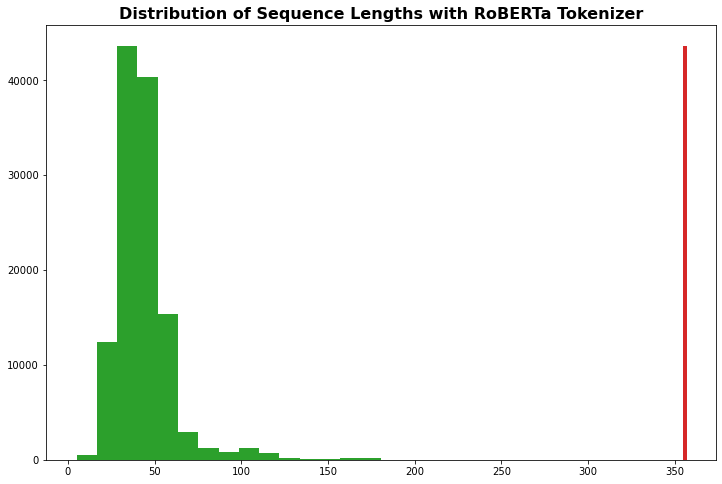

In [76]:
fig, ax =plt.subplots(1,1, figsize=(12,8))
h = ax.hist(rtoken_lengths, bins=30, color='tab:green')
ax.set_title('Distribution of Sequence Lengths with RoBERTa Tokenizer', fontweight='bold',fontsize=16)
ax.vlines(np.max(rtoken_lengths), 0, max(h[0]),color='tab:red', linewidth=4)

In [ ]:
rtokens = []
for sent in tqdm(train_sentences):
    rtokens.append(rtokenizer.encode(sent))
rtoken_lengths = [len(t) for t in rtokens]

In [73]:
print(f'Average Sequence Length with BERT Tokenizer: {np.mean(token_lengths):3.2f}')
print(f'Average Sequence Length with Roberta Tokenizer: {np.mean(rtoken_lengths):3.2f}')
print(50*'-')
print(f'Maximum Sequence Length with BERT Tokenizer: {np.max(token_lengths):3.2f}')
print(f'Maximum Sequence Length with Roberta Tokenizer: {np.max(rtoken_lengths):3.2f}')

Average Sequence Length with BERT Tokenizer: 43.36
Average Sequence Length with Roberta Tokenizer: 43.71
--------------------------------------------------
Maximum Sequence Length with BERT Tokenizer: 372.00
Maximum Sequence Length with Roberta Tokenizer: 356.00


In [89]:
np.math.log(2.7)


0.9932517730102834

In [92]:
110000000*64/1e9

7.04